In [1]:
from glob import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2 as cv
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import CenterCrop, ToPILImage

In [2]:
path = '/kaggle/input/gdsc-nu-ml-hackathon-bts-case-competition/'

train_images = sorted(glob(path+"train/imgs/*"))
train_masks = sorted(glob(path+"train/masks/*"))
test_images = sorted(glob(path+"test/imgs/*"))
len(train_images), len(train_masks), len(test_images)

(240, 240, 80)

In [3]:
H, W = 576, 768
TH = 0.85

In [4]:
def read_data(images):
    tr = torch.empty((len(images), 3, H, W))
    for i in range(len(images)):
        image = images[i]
        
        np = cv.imread(image)
        tr[i] = torch.tensor(np / 255).permute(2, 0, 1)
        
    return tr

def get_y(masks):
    y = masks.mean(axis=1)
    y = torch.where(y > 0.5, torch.tensor([1.0]), torch.tensor([0.0])).float()
    return y
        
def split(dataset, val_percent):
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    return train_set, val_set

def add_channels(mask):
    n_mask = torch.empty((mask.shape[0], 3, H, W)).to(device)
    for i in range(mask.shape[0]):
        n_mask[i][0] = torch.where(mask[i] > TH, torch.tensor([255]), torch.tensor([0.0])).int()
        n_mask[i][1] = torch.where(mask[i] > TH, torch.tensor([255]), torch.tensor([0.0])).int()
        n_mask[i][2] = torch.where(mask[i] > TH, torch.tensor([255]), torch.tensor([0.0])).int()
    return n_mask

In [5]:
train_images_tr = read_data(train_images)
train_masks_tr = read_data(train_masks)
test_images_tr = read_data(test_images)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, im_tr, msk_tr):
        self.X = im_tr
        self.y = get_y(msk_tr)
#         self.y = msk_tr
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
dataset = ImageDataset(train_images_tr, train_masks_tr)

train_set, val_set = split(dataset, 0)

train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(val_set, batch_size=1)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)
    
class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output

    
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.copyAndCrop = CopyAndCrop()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])


        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])


        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encode
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output
    
model = UNet(in_channels=3, out_channels=1)
model.cuda()

UNet(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      

In [8]:
optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.MSELoss()

In [9]:
from tqdm import tqdm


epoch = 10
for e in range(epoch):
    sum = 0
    for batch in tqdm(train_loader):
        X, y = batch
        X, y = X.cuda(), y.cuda()
        y_pred = model(X)        
        loss = criterion(y_pred, y)
        sum += loss.item()
        assert not torch.isnan(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(e + 1, sum)

  0%|          | 0/240 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 576, 768])) that is different to the input size (torch.Size([1, 1, 576, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


1 5.457207918167114


100%|██████████| 240/240 [02:00<00:00,  1.99it/s]


2 1.574638113612309


100%|██████████| 240/240 [02:00<00:00,  1.98it/s]


3 0.7865904055070132


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


4 0.6031912444159389


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


5 0.513039727578871


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


6 0.4695600678678602


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


7 0.4075832077069208


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


8 0.3823904151795432


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]


9 0.36756239901296794


100%|██████████| 240/240 [02:01<00:00,  1.98it/s]

10 0.35442944383248687


In [10]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = 'cpu'

In [11]:
predictions = []

with torch.inference_mode():
    for i in range(len(test_images_tr)):
        prediction = model(test_images_tr[i].unsqueeze(dim=0).to(device))
        predictions.append(add_channels(prediction.cpu()))

In [12]:
new_path = 'test_masks'
os.mkdir(new_path)

In [13]:
for i in range(len(predictions)):
    tensor = predictions[i].squeeze(dim=0).permute(1, 2, 0)
    np_arr = tensor.cpu().numpy()
    #tensor = tensor.mul(255)
    filename = test_images[i].split('/')[-1][:-3] + 'png'
    cv.imwrite('test_masks/'+filename, np_arr)
    print('test_masks/'+filename, np_arr.shape)

test_masks/Image0161.png (576, 768, 3)
test_masks/Image0162.png (576, 768, 3)
test_masks/Image0163.png (576, 768, 3)
test_masks/Image0164.png (576, 768, 3)
test_masks/Image0165.png (576, 768, 3)
test_masks/Image0166.png (576, 768, 3)
test_masks/Image0167.png (576, 768, 3)
test_masks/Image0168.png (576, 768, 3)
test_masks/Image0169.png (576, 768, 3)
test_masks/Image0170.png (576, 768, 3)
test_masks/Image0171.png (576, 768, 3)
test_masks/Image0172.png (576, 768, 3)
test_masks/Image0173.png (576, 768, 3)
test_masks/Image0174.png (576, 768, 3)
test_masks/Image0175.png (576, 768, 3)
test_masks/Image0176.png (576, 768, 3)
test_masks/Image0177.png (576, 768, 3)
test_masks/Image0178.png (576, 768, 3)
test_masks/Image0179.png (576, 768, 3)
test_masks/Image0180.png (576, 768, 3)
test_masks/Image0181.png (576, 768, 3)
test_masks/Image0182.png (576, 768, 3)
test_masks/Image0183.png (576, 768, 3)
test_masks/Image0184.png (576, 768, 3)
test_masks/Image0185.png (576, 768, 3)
test_masks/Image0186.png 

In [14]:
import cv2
import pandas as pd

filenames = sorted(glob("test_masks/*"))
responses = []
for i, file in enumerate(filenames):
    print(i, file)
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    coords = list(np.where(img.flatten()>0)[0])
    short_coords = [str(coords[0])]
    j = 1
    length = 1
    while j != len(coords):
        if coords[j]-1 in coords:
            length += 1
        else:
            short_coords.append(str(length))
            short_coords.append(str(coords[j]))
            length = 1
        j += 1
    short_coords.append(str(length))
        
    responses.append([i] + [" ".join(short_coords)])

sample = pd.DataFrame(responses, columns=["ImageID", "Expected"])
sample.to_csv("submission.csv", index=None)

0 test_masks/Image0161.png
1 test_masks/Image0162.png
2 test_masks/Image0163.png
3 test_masks/Image0164.png
4 test_masks/Image0165.png
5 test_masks/Image0166.png
6 test_masks/Image0167.png
7 test_masks/Image0168.png
8 test_masks/Image0169.png
9 test_masks/Image0170.png
10 test_masks/Image0171.png
11 test_masks/Image0172.png
12 test_masks/Image0173.png
13 test_masks/Image0174.png
14 test_masks/Image0175.png
15 test_masks/Image0176.png
16 test_masks/Image0177.png
17 test_masks/Image0178.png
18 test_masks/Image0179.png
19 test_masks/Image0180.png
20 test_masks/Image0181.png
21 test_masks/Image0182.png
22 test_masks/Image0183.png
23 test_masks/Image0184.png
24 test_masks/Image0185.png
25 test_masks/Image0186.png
26 test_masks/Image0187.png
27 test_masks/Image0188.png
28 test_masks/Image0189.png
29 test_masks/Image0190.png
30 test_masks/Image0191.png
31 test_masks/Image0192.png
32 test_masks/Image0193.png
33 test_masks/Image0194.png
34 test_masks/Image0195.png
35 test_masks/Image0196.png
36

In [15]:
# !rm -r 'test_masks'

In [16]:
def plot():
    print(f"Threshold = {TH}")
    for i in os.listdir('/kaggle/input/gdsc-nu-ml-hackathon-bts-case-competition/test/imgs/')[:10]:
        img1 = cv2.imread('/kaggle/input/gdsc-nu-ml-hackathon-bts-case-competition/test/imgs/'+i)
        img2 = cv2.imread('test_masks/'+i.split('.')[0]+'.png')

        fig, ax = plt.subplots(ncols=2, figsize=(8,8))
        ax[0].imshow(img1)
        ax[1].imshow(img2)

        ax[0].set_title(i)
        ax[1].set_title('test_masks/'+i.split('.')[0]+'.png')
        plt.show()

Threshold = 0.85


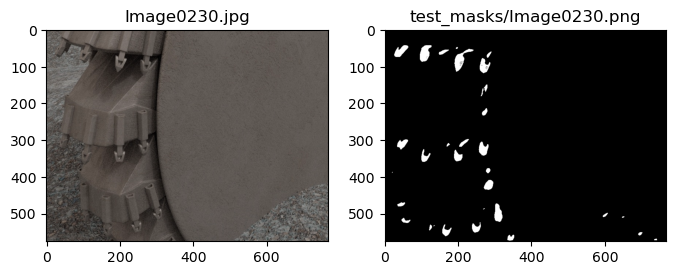

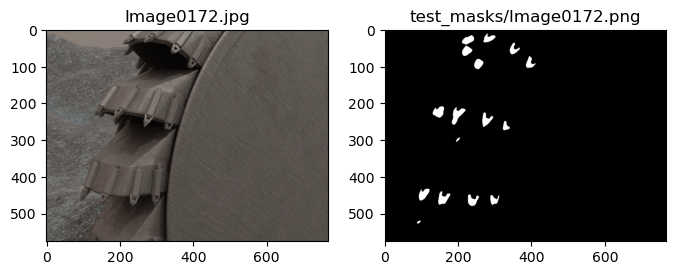

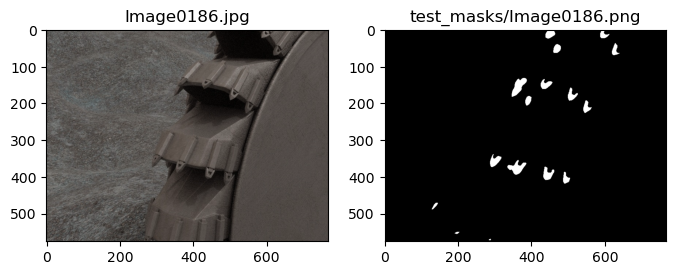

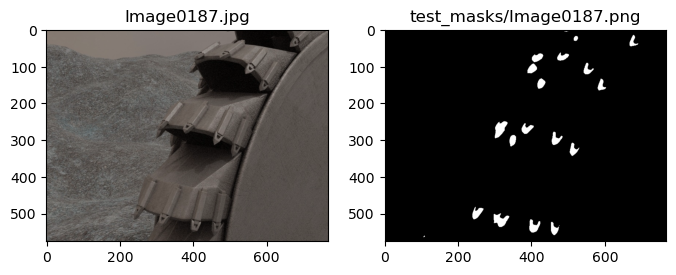

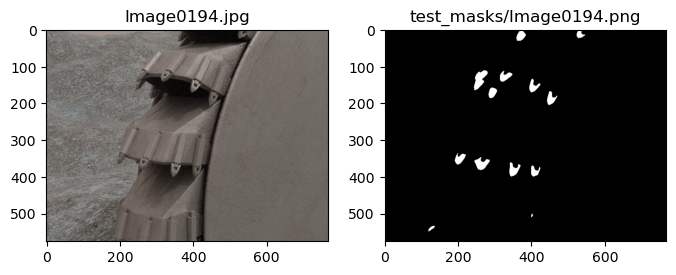

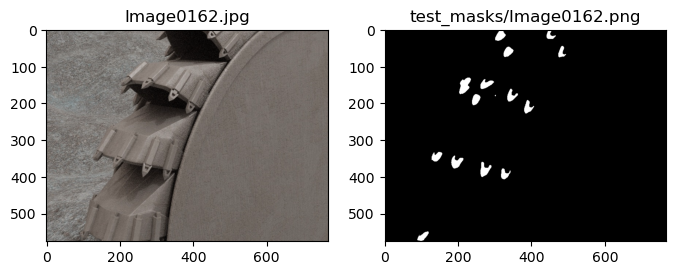

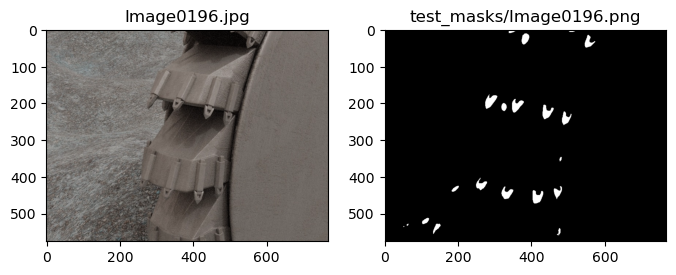

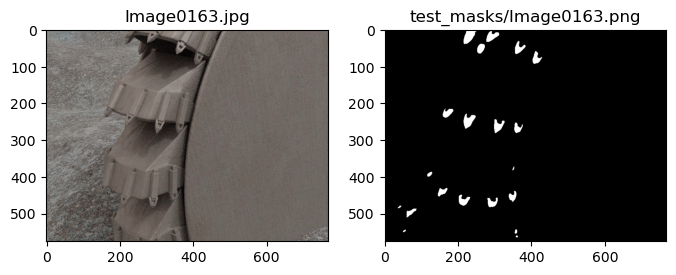

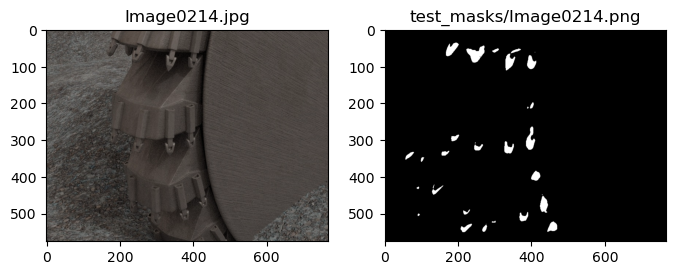

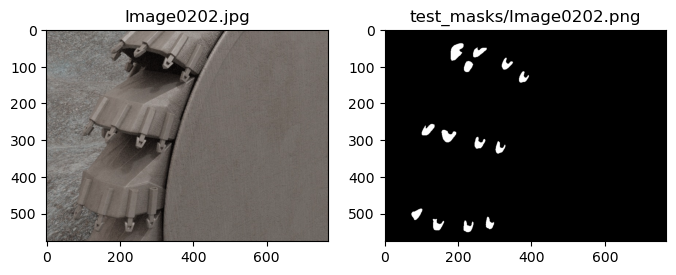

In [17]:
plot()

Threshold = 0.85


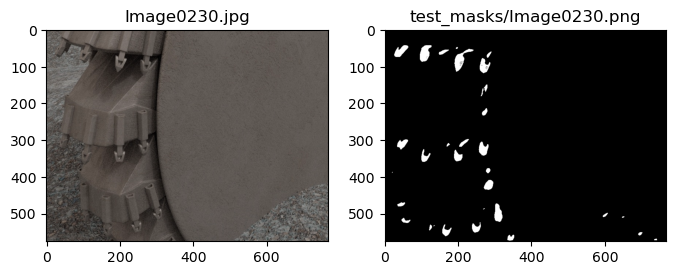

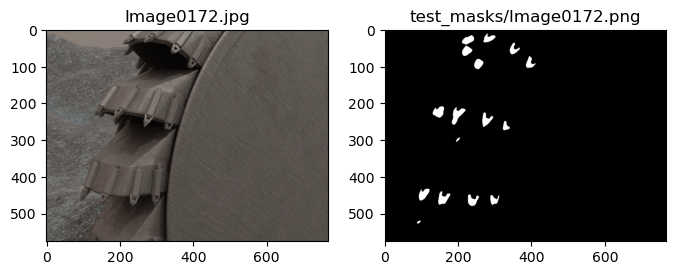

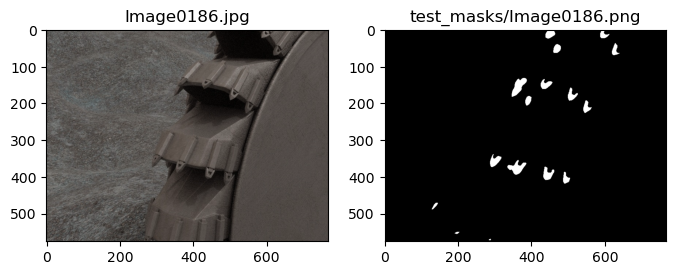

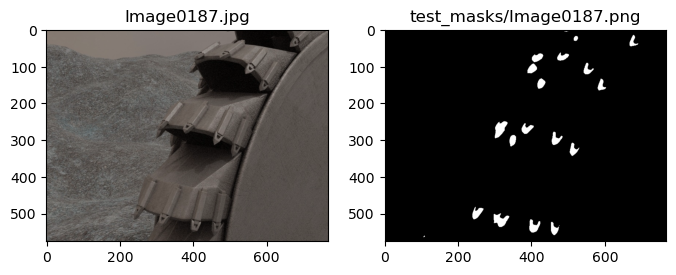

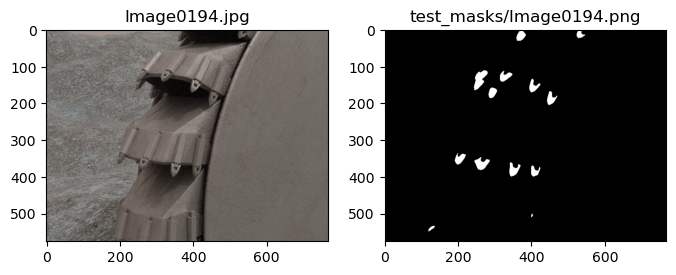

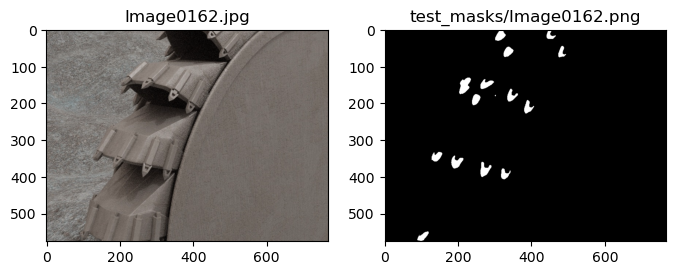

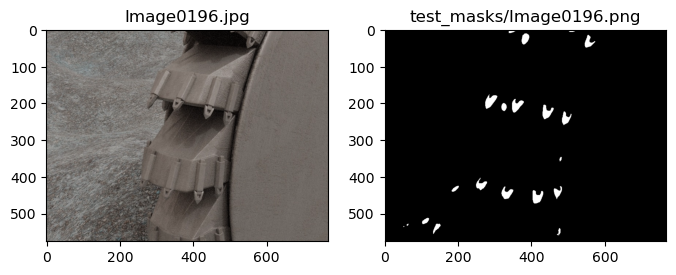

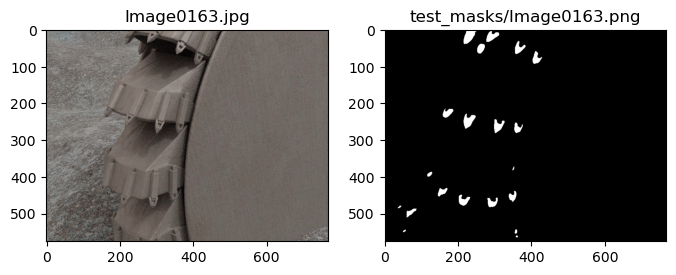

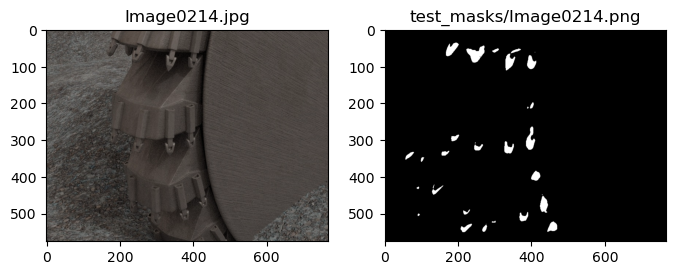

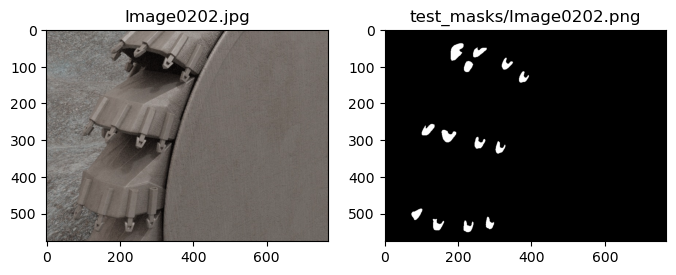

In [18]:
plot()

Threshold = 0.85


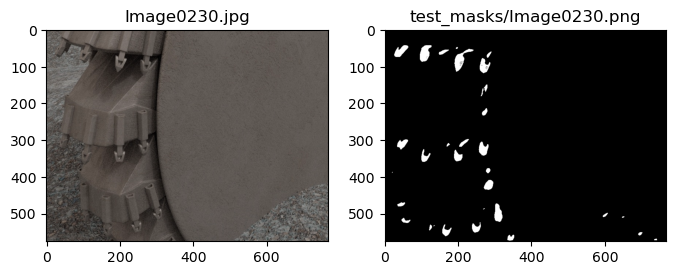

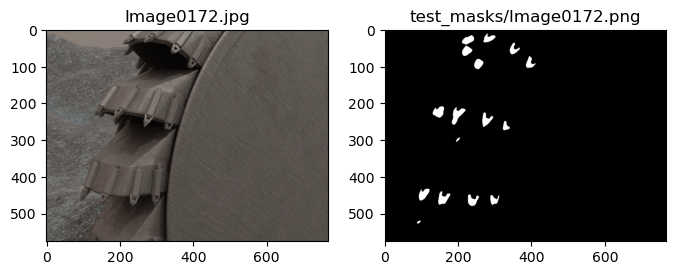

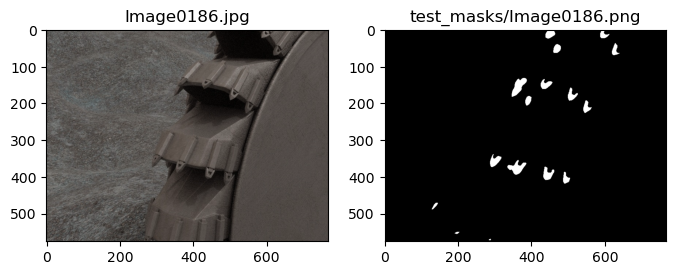

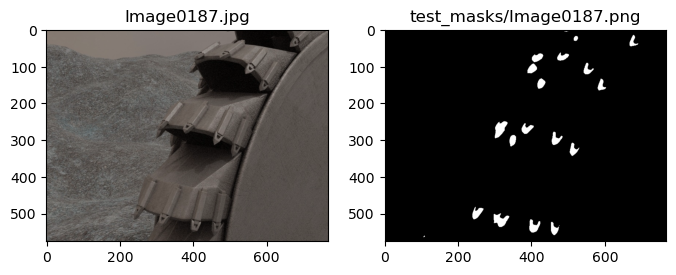

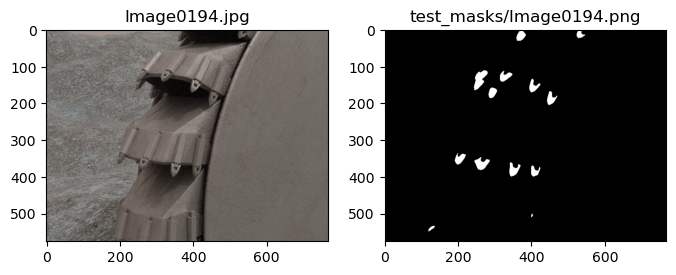

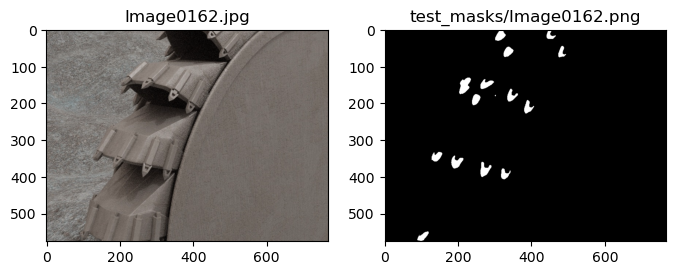

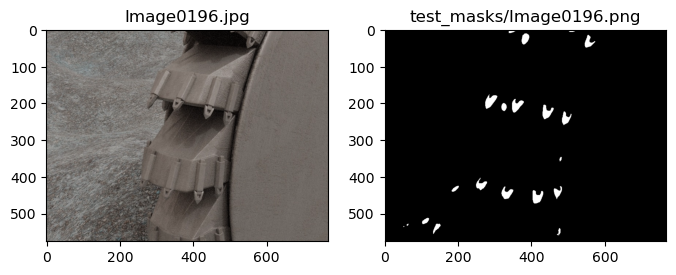

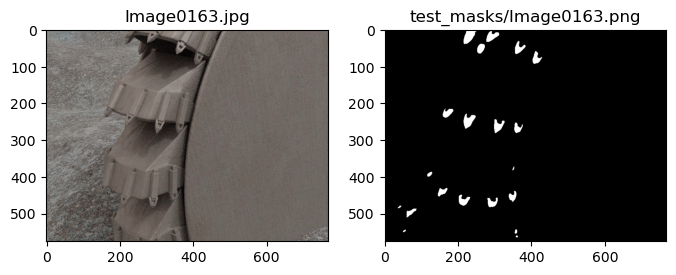

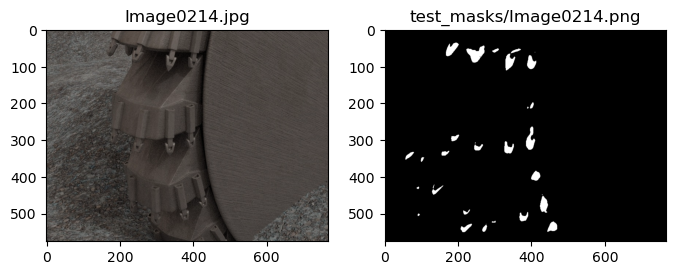

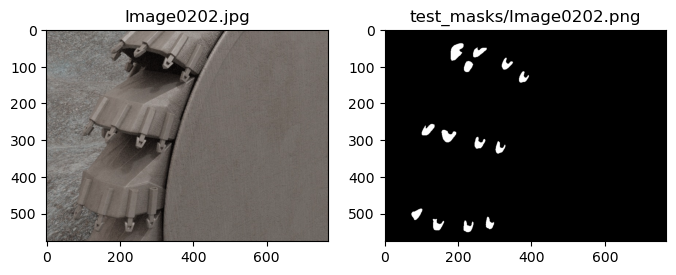

In [19]:
plot()

Threshold = 0.85


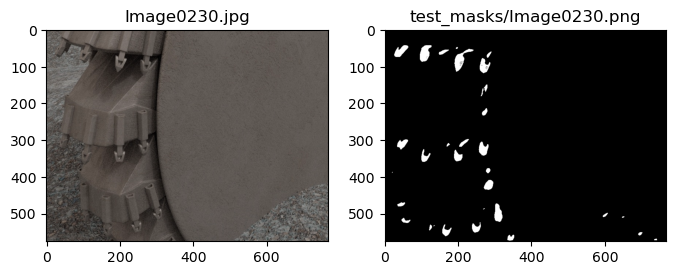

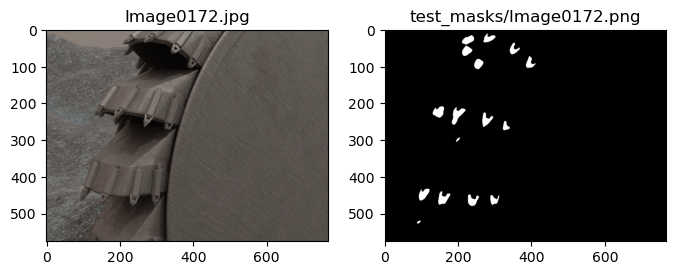

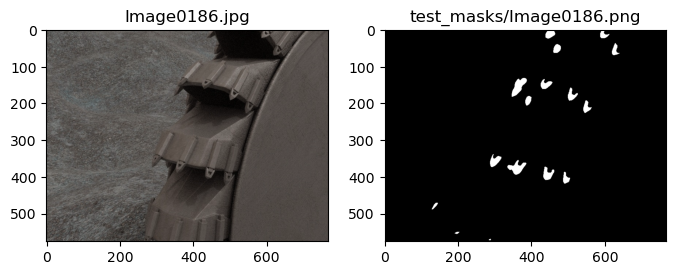

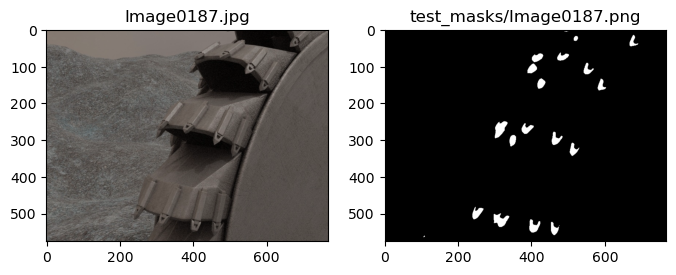

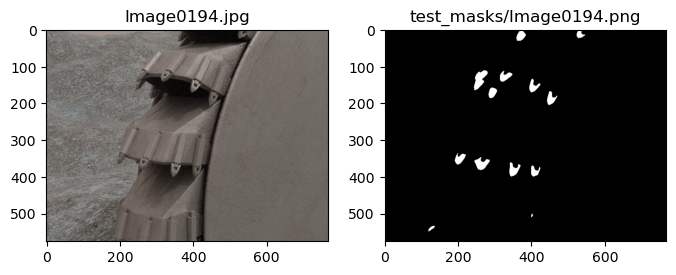

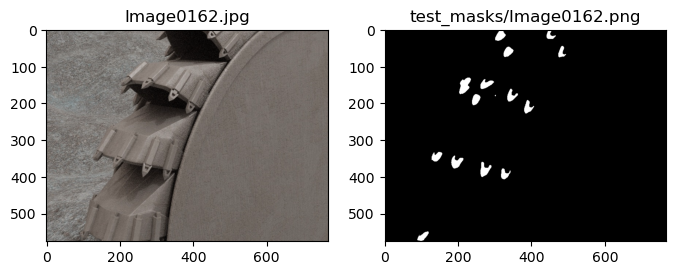

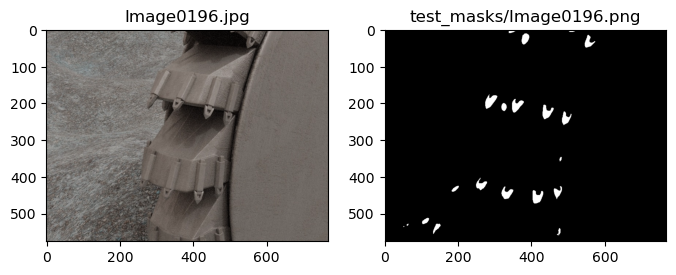

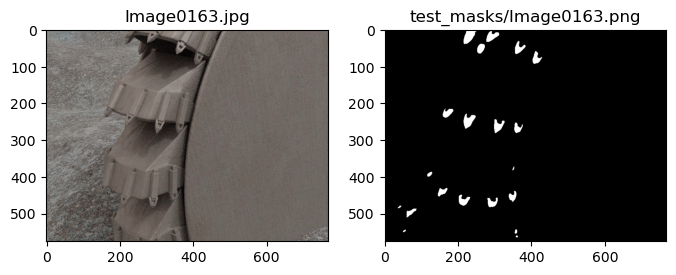

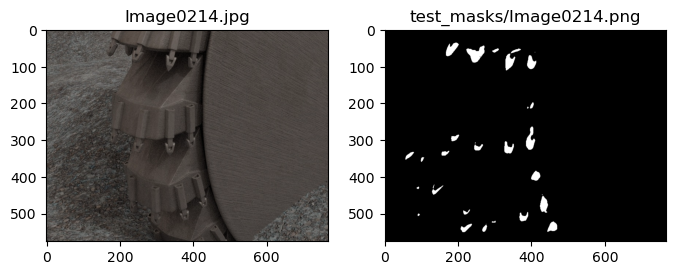

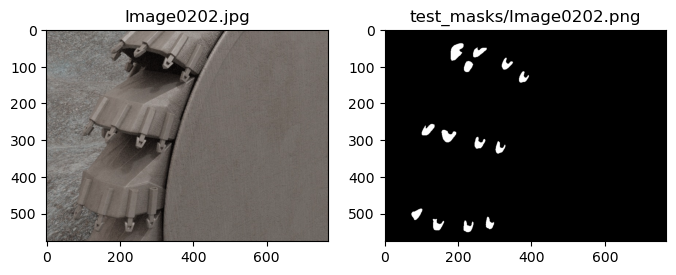

In [20]:
plot()

Threshold = 0.85


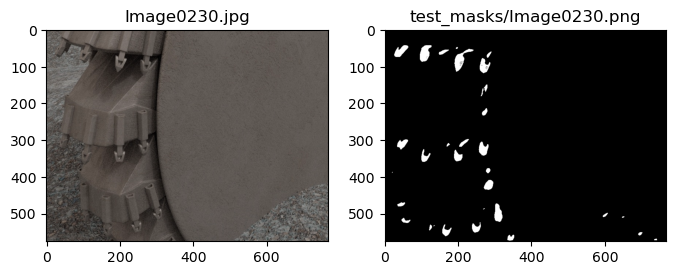

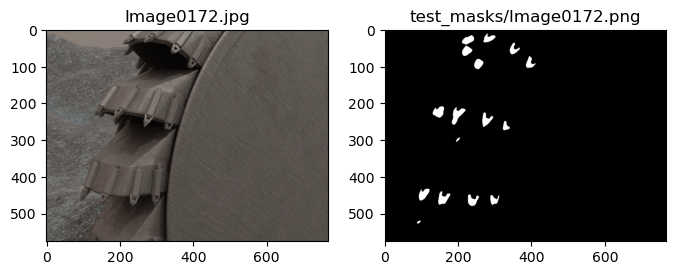

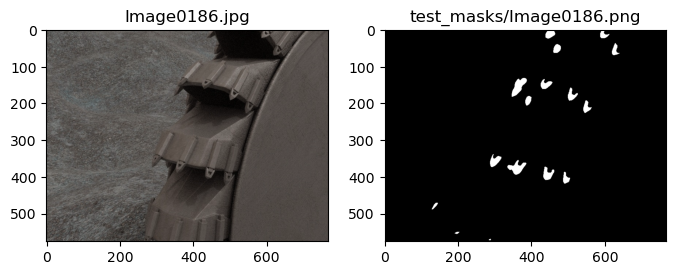

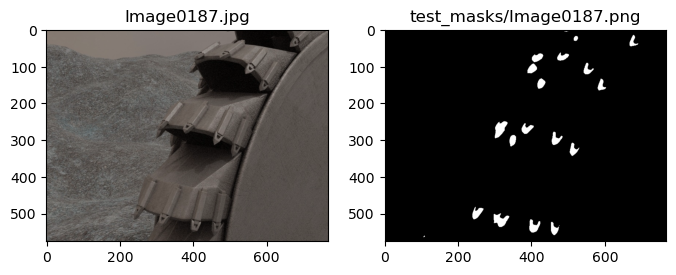

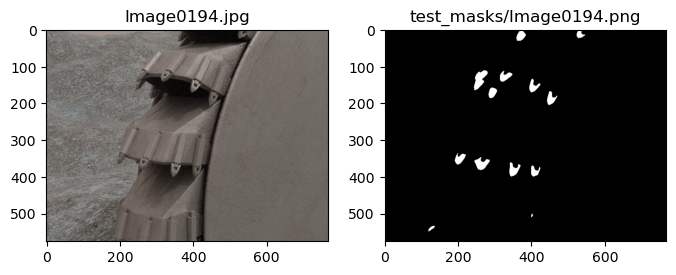

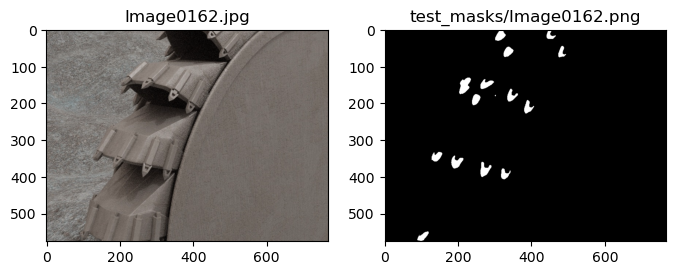

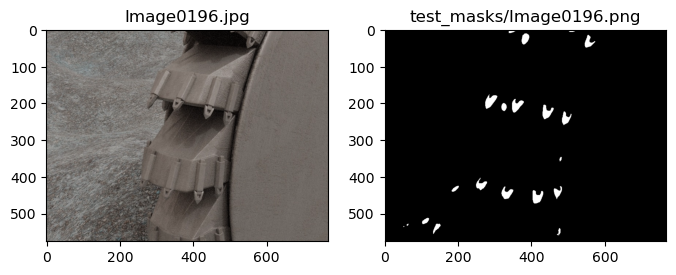

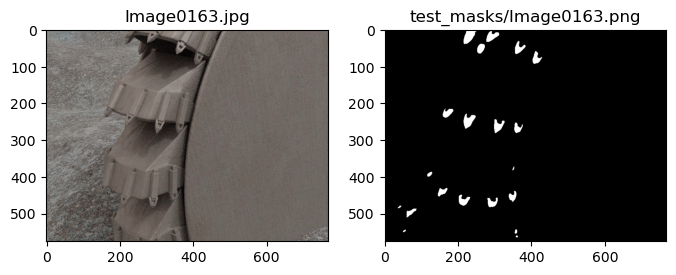

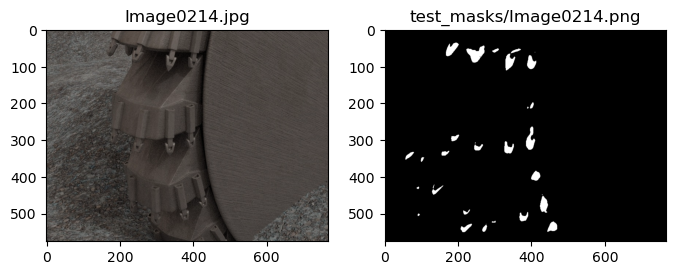

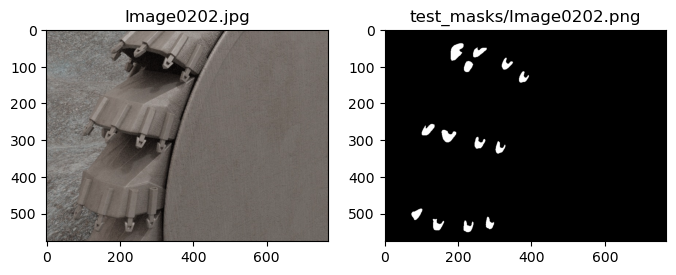

In [21]:
plot()